In [1]:
import os
import dill
import bilby
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm

from util import get_bilby_longname, plot_single_evolution, violinplot

%load_ext autoreload
%autoreload 2

In [2]:
### plot settings and colors
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "Computer Modern Roman"
mpl.rcParams["font.size"] = 20
mpl.rcParams["text.usetex"] = True
mpl.rcParams["grid.alpha"] = 0

mpl.rcParams["figure.dpi"] = 300

In [3]:
### relevant injected values
dpi_vals = dict(
    d_phi_0 = 0, d_phi_1 = 0, d_phi_2 = 0.2, d_phi_3 = 0, d_phi_4 = 0,
    d_phi_5L = 0, d_phi_6 = 0, d_phi_6L = 0, d_phi_7 = 0,
    d_alpha_2 = 0, d_alpha_3 = 0, d_alpha_4 = 0,
    d_beta_2 = 0, d_beta_3 = 0
)

chirp_mass = 30
mass_ratio = 0.8

# Read hybrid results

In [4]:
outdir = "/home/noah.wolfe/bgr_source_model/paper_runs/highsnr-bgr-injection/hybrid/hybrid-highsnr-bgr-injection"
label  = "hybrid-highsnr-bgr-injection"
longname = get_bilby_longname(label)

queue_path = "/home/noah.wolfe/bgr_source_model/paper_runs/highsnr-bgr-injection/hybrid/queue.txt"

In [5]:
dpi_runs = dict()

with open(queue_path, "r") as dpi_run_file:
    for run in tqdm(dpi_run_file.readlines()):
        dpi, overlap = [ s.strip() for s in run.strip().split(",") ]
        result_path  = os.path.join(
            outdir, "result", 
            f"{longname}_{dpi}_overlap-{overlap}_result.json"
        )

        if os.path.isfile(result_path):
            dpi_runs[(dpi, overlap, "hybrid")] = bilby.core.result.read_in_result(result_path)

100%|██████████| 28/28 [00:57<00:00,  2.04s/it]


# Read `dynesty`-only results

In [6]:
verif_parentdir = "/home/noah.wolfe/bgr_source_model/paper_runs/highsnr-bgr-injection/verification"

unique_dpi = set([ run[0] for run in dpi_runs ])

for dpi in tqdm(unique_dpi):
    verif_label = f"dynesty-highsnr-bgr-injection_{dpi}"
    verif_longname = get_bilby_longname(verif_label)
    
    verif_outdir = os.path.join(verif_parentdir, verif_label)
    if not os.path.isdir(verif_outdir):
        print(f"Missing a verification run outdir for {dpi}!")
        continue

    verif_resultpath = os.path.join(verif_outdir, "result", f"{verif_longname}_dynesty_result.json")
    if not os.path.isfile(verif_resultpath):
        print(f"Missing a verification run result for {dpi}!")
        continue

    dpi_runs[(dpi, "0.0", "verif")] = bilby.core.result.read_in_result(verif_resultpath)

100%|██████████| 14/14 [00:00<00:00, 1526.95it/s]

Missing a verification run result for d_alpha_2!
Missing a verification run result for d_phi_6!
Missing a verification run result for d_beta_2!
Missing a verification run result for d_phi_1!
Missing a verification run result for d_phi_4!
Missing a verification run result for d_phi_5L!
Missing a verification run result for d_phi_6L!
Missing a verification run result for d_phi_2!
Missing a verification run result for d_alpha_3!
Missing a verification run result for d_phi_0!
Missing a verification run result for d_beta_3!
Missing a verification run result for d_phi_3!
Missing a verification run outdir for d_phi_7!
Missing a verification run result for d_alpha_4!


# Violinplots

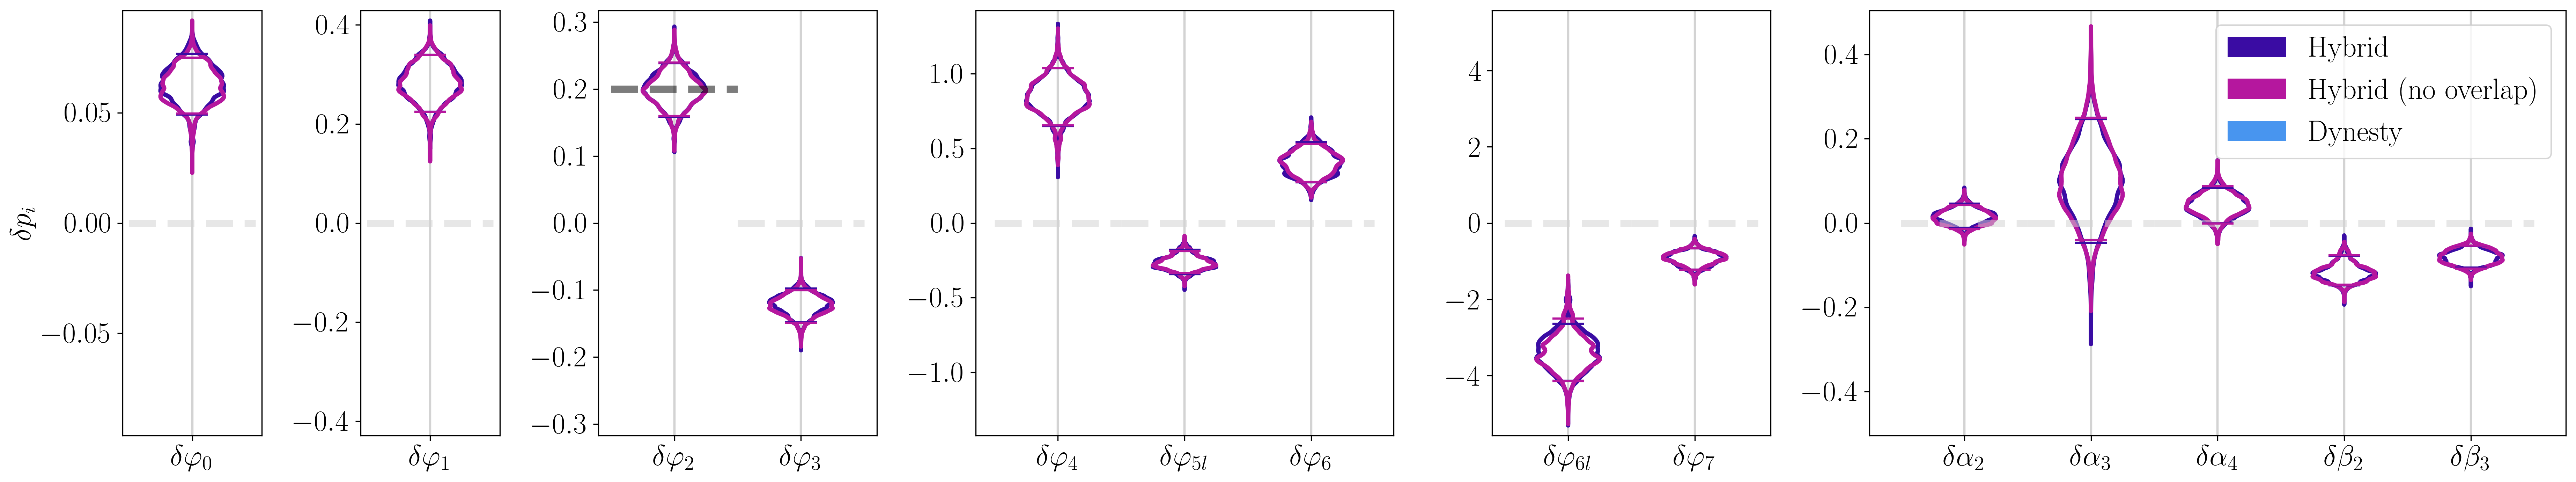

In [6]:
fig, axes = violinplot(dpi_runs, "dpi", dpi_vals, r"$\delta p_i$", "Dynesty", fig_kwargs=dict(figsize=(25,5)) )

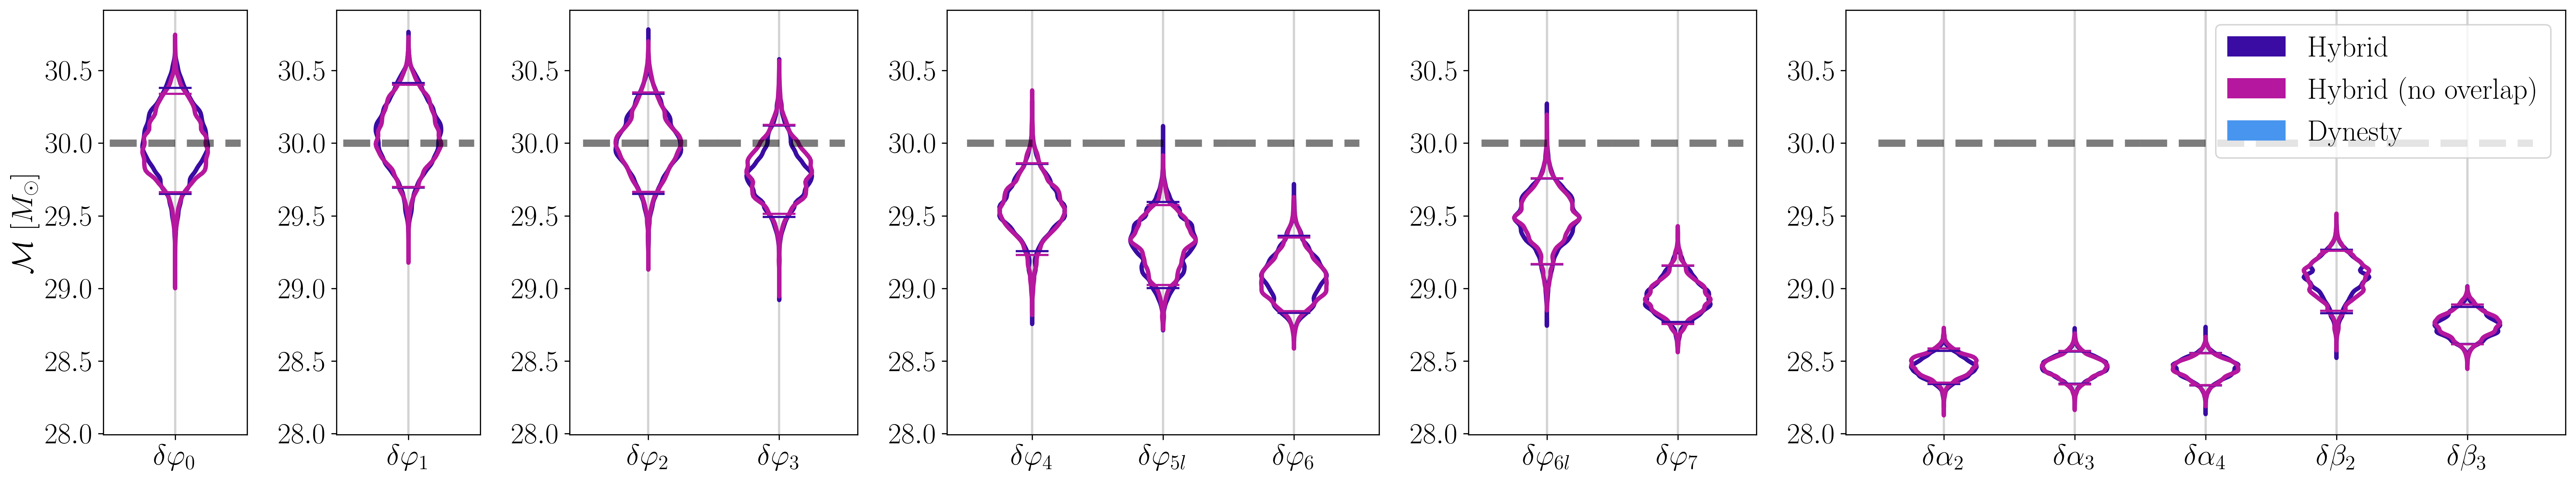

In [8]:
fig, axes = violinplot(dpi_runs, "chirp_mass", chirp_mass, r"$\mathcal{M}$ [$M_{\odot}$]", "Dynesty", square_y=False, share_y=True, fig_kwargs=dict(figsize=(25,5)) )

# Corner Plot from $\delta \varphi_2$ run

In [9]:
result_hybrid  = dpi_runs[("d_phi_2", "0.9", "hybrid")]
result_dynesty = dpi_runs[("d_phi_2", "0.0", "dynesty")]

bilby.core.result.plot_multiple(
    [result_dynesty, result_hybrid],
    labels = ["Dynesty", "Hybrid"],
    colours = ["#4895ef", "#3a0ca3"],
    parameters = dict(
        d_phi_2 = dpi_vals["d_phi_2"],
        mass_ratio = mass_ratio,
        chirp_mass = chirp_mass,
        ra = 1.35,
        dec = -1.21
    ),
    titles = False,
    truth_color = "black",
    dpi = 300
)

KeyError: ('d_phi_2', '0.0', 'dynesty')

# Evolution Snapshot

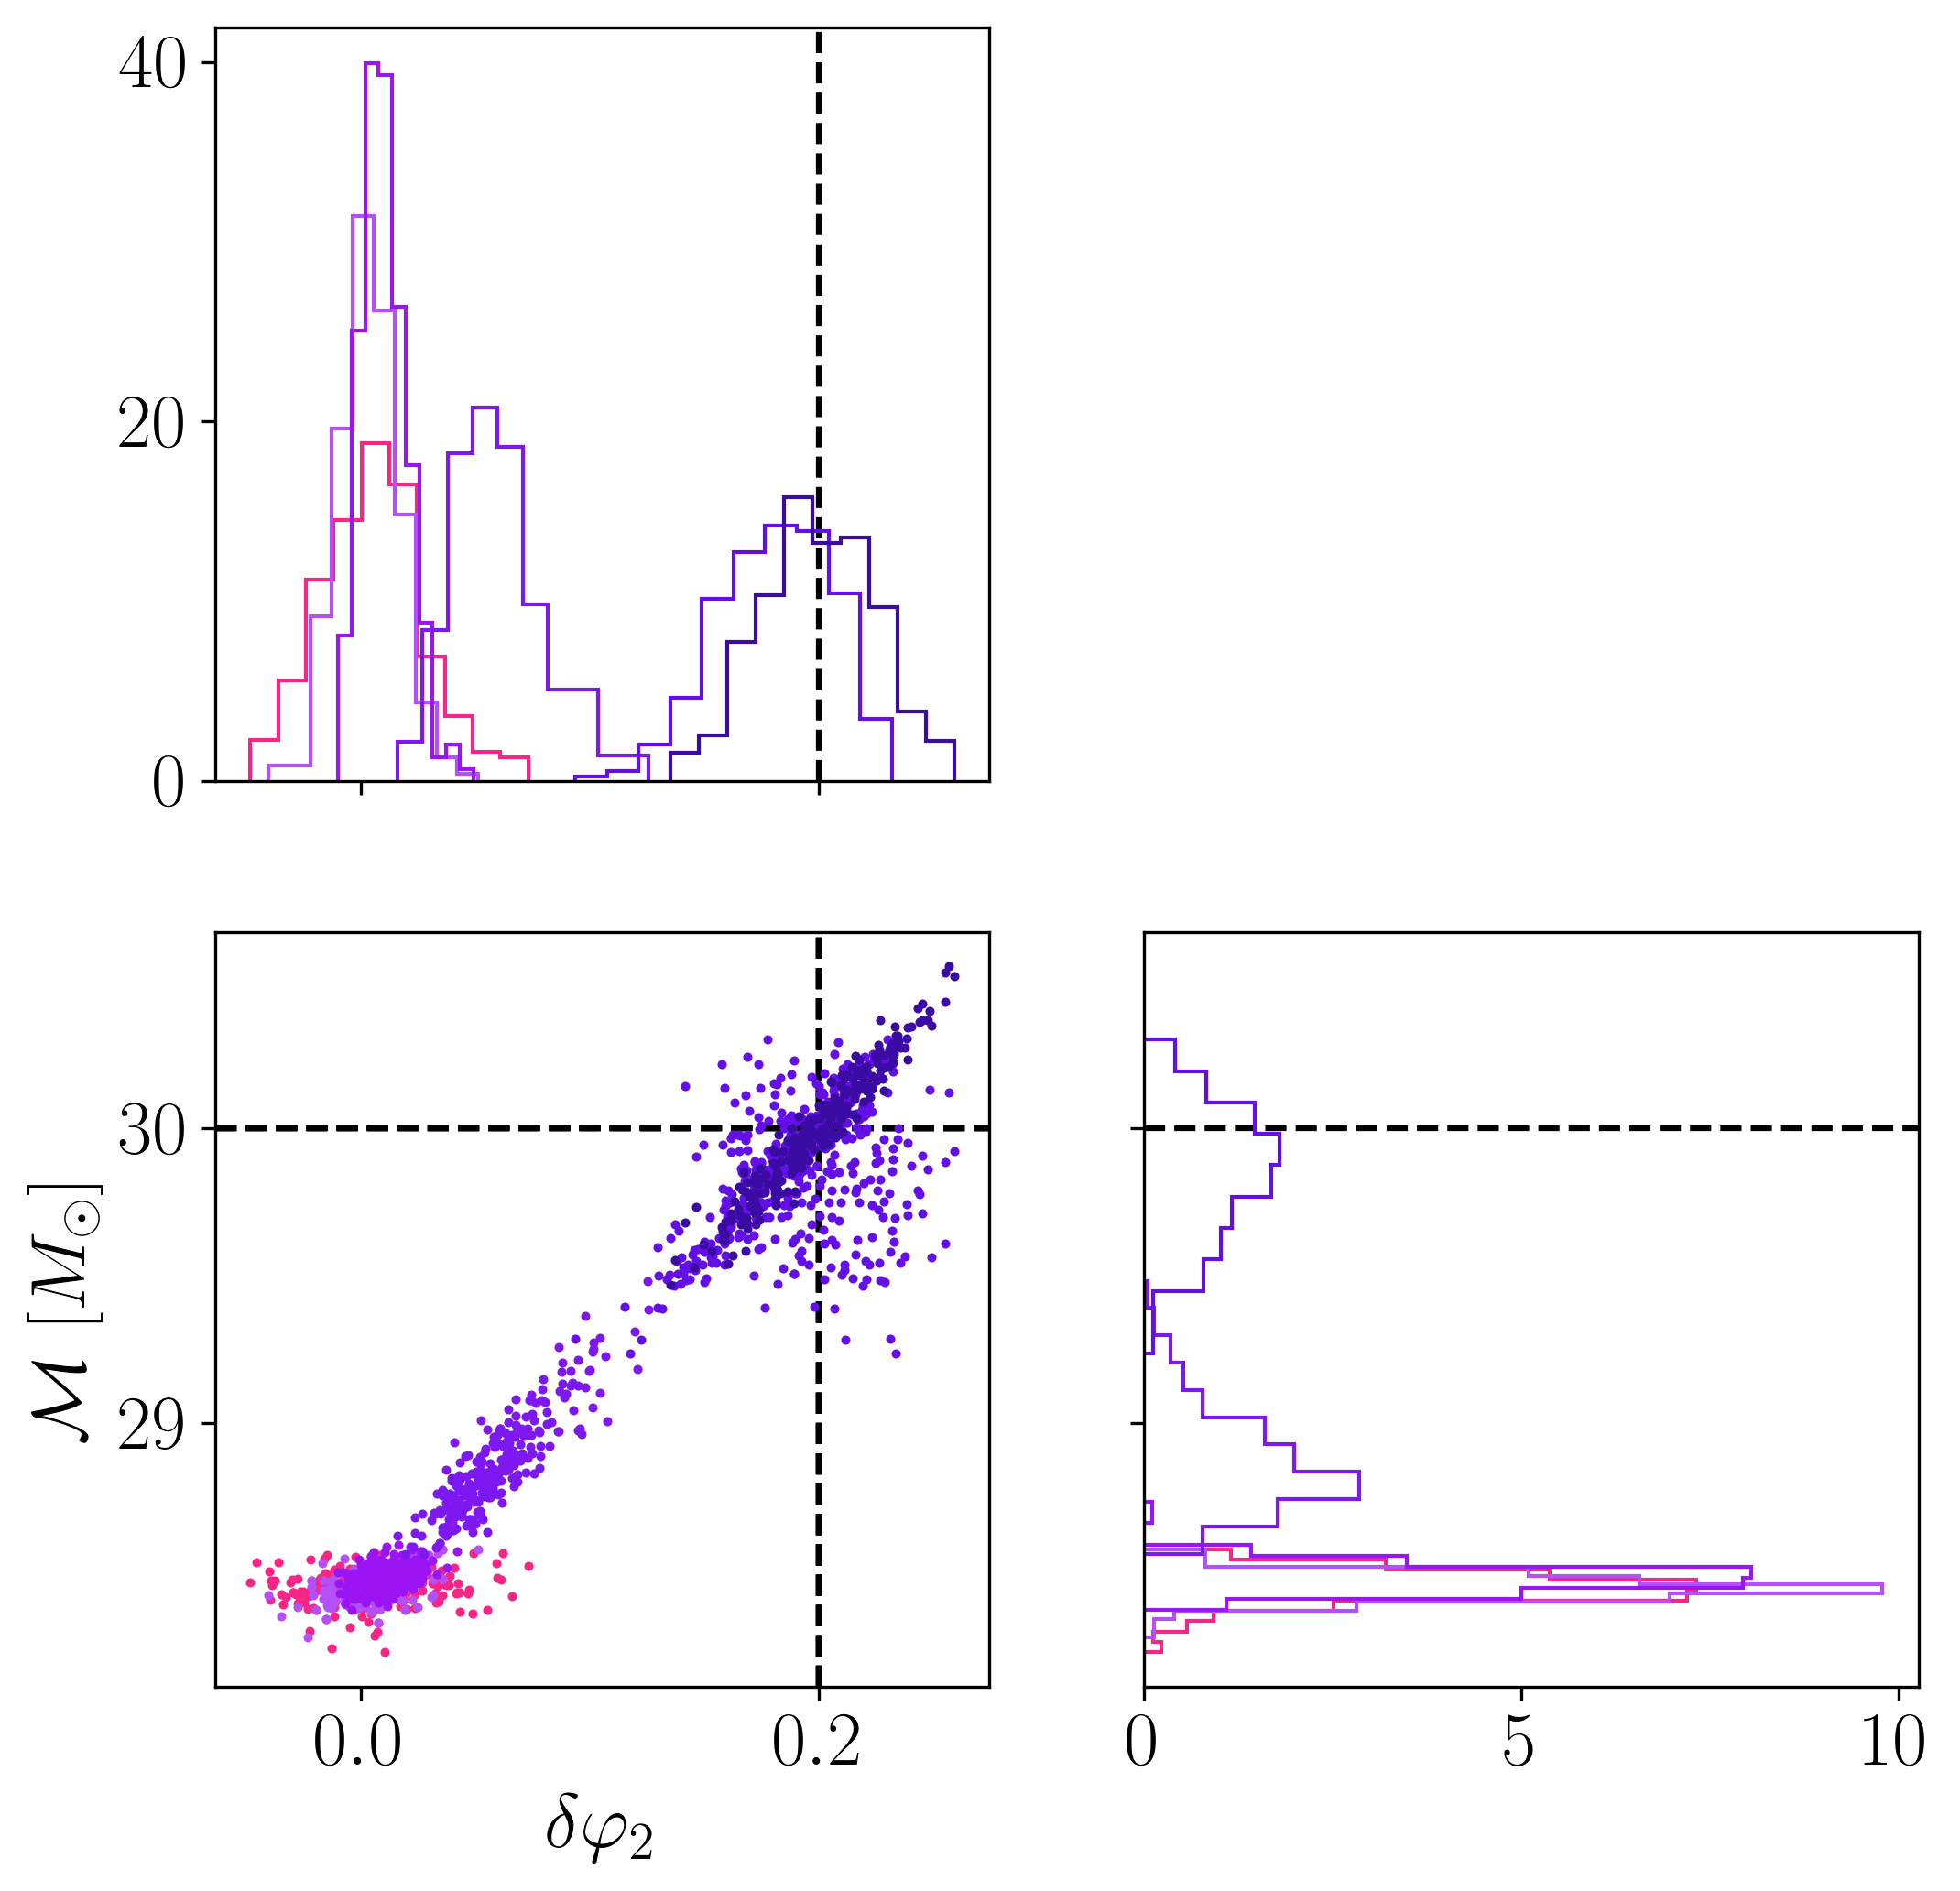

In [49]:
# load hybrid samples
resume_hybrid_path = os.path.join(
    outdir, "result", 
    f"{bilby_longname}_d_phi_2_overlap-0.9_checkpoint_resume.pickle"
)
with open(resume_hybrid_path, "rb") as f:
    resume_hybrid = dill.load(f)

# refer to final hybrid result
result_hybrid = dpi_runs[("d_phi_2", "0.9", "hybrid")]

from util import plot_single_evolution

# TODO: remove y-axis labels from histograms?
# TODO: add legend!
# TODO: calculate (numerically?) the 'orange line' that should follow the trend in the scatter plot
iterations = [ 1, 2, 16, 128, 1024, 2048 ]
fig, axes = plot_single_evolution(
    result_hybrid, resume_hybrid, 
    "d_phi_2", "chirp_mass", r"$\delta \varphi_2$", r"$\mathcal{M}$ [$M_{\odot}$]",
    dpi_vals["d_phi_2"], chirp_mass,
    iterations = iterations
)